In [1]:
!pip install welly

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:

import os
import sys
import json
import welly
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
import numpy as np

%matplotlib inline

In [5]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [6]:
# where WellClass and Ga[ codes are located
sys.path.append('../')

In [7]:
# WellClass
# from well_class_v2 import csv_parser, Well
from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser
)

from src.WellClass.libs.well_class import Well
from src.WellClass.libs.well_pressure import Pressure



# plots
from src.WellClass.libs.plotting import (
    plot_pressure,
    plot_pt,
    plot_sketch,
)

## Some user options

In [8]:
# use yaml or csv input file
use_yaml = False

In [9]:
# pick an example from given three options

case_type = 'wildcat'

case_type = 'smeaheia_v1'

case_type = 'frigg'

In [10]:
# where pvt located
pvt_path = '../src/WellClass/libs/pvt/pvt_constants/pure_co2'

# Examples

The following are the test examples.

In [11]:
# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
               'sim_path': r'../test_data/examples/smeaheia_v1',
               'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
               'sim_path': r'../test_data/examples/smeaheia_v2', 
               'simcase': r'TEMP-0'}
wildcat = {
         'well_input': r'GaP_input_Wildcat_v3.csv', 
         'well_input_yaml': r'wildcat.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
         'sim_path': r'../test_data/examples/wildcat', 
         'simcase': r'TEMP-0'}
frigg = {
         'well_input': r'GaP_input_Frigg_v3.csv', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
         'sim_path': r'../test_data/examples/frigg', 
         'simcase': r'TEMP-0'}

In [12]:
examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'wildcat': wildcat,
    'frigg': frigg
}

# Load well CSV or yaml configuration file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [13]:
# the selected example for testing
case = examples[case_type]


In [14]:

# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

sim_path = case['sim_path']


In [15]:
if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)

# Load Deviation survey and compute TVDRKB to be used as MD

In [16]:
welly_well = welly.Well()
dev_survey_file = r'../test_data/examples/frigg/frigg_dev_survey.txt'
survey = np.loadtxt(dev_survey_file, skiprows=1, dtype={'names':('Wellname',
                                                                 'UWN',
                                                                 'UTMnorth',
                                                                 'UTMeast',
                                                                 'MeasDepth(m)',
                                                                 'MeasTVD(m)',
                                                                 'Dip',
                                                                 'Azimuth',
                                                                 'Location(NS)',
                                                                 'Location(EW)',
                                                                 'Dogleg'),
                                                                 'formats':['|S10']+10*[float]})


welly_well.location.add_deviation(  np.stack([survey['MeasDepth(m)'], survey['Dip'],survey['Azimuth']]).T, td=4721)

trajectory = welly_well.location.trajectory(elev=True, datum=(0, 0, well_csv['well_header']['well_rkb']))

#Horizontal offset of the well
hoz_offset = np.sqrt(welly_well.location.position[:,0]**2+welly_well.location.position[:,1]**2)




### Update all values in well_csv

In [17]:
import copy
well_csv_dev = copy.deepcopy(well_csv)

drilling_df = pd.DataFrame(well_csv['drilling'])
casing_df = pd.DataFrame(well_csv['casing_cement'])
barriers_df = pd.DataFrame(well_csv['barriers'])
geology_df = pd.DataFrame(well_csv['geology'])


# Update the drilling data
drilling_df['top_rkb'] = welly_well.location.md2tvd(drilling_df['top_rkb'])
drilling_df['bottom_rkb'] = welly_well.location.md2tvd(drilling_df['bottom_rkb'])

# Update the casing data
for col in ['top_rkb', 'bottom_rkb', 'toc_rkb', 'boc_rkb']:
    casing_df[col] = welly_well.location.md2tvd(casing_df[col])

# Update the barriers data
for col in ['top_rkb', 'bottom_rkb']:
    barriers_df[col] = welly_well.location.md2tvd(barriers_df[col])

# Update the geology data
geology_df['top_rkb'] = welly_well.location.md2tvd(geology_df['top_rkb'])


well_csv_dev['drilling'] = drilling_df.to_dict()
well_csv_dev['casing_cement'] = casing_df.to_dict()
well_csv_dev['barriers'] = barriers_df.to_dict()
well_csv_dev['geology'] = geology_df.to_dict()


# Run Well Class

In [18]:
#Process well by running well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
           )

## Generation of Pressure tables
### 1. Minimum input: 

The pressure class can be initialized with a minimum of the following parameters:
- Depth to seabed in mTVDMSL
- Wellbore TD in mRKB
- Wellbore RKB in mTVDMSL
- Seafloor temperature in degC. Defaulted to 4 degC
- Geothermal gradient in degC/km. Defaulted to 40 degC/km
- Fluid type: This depends on the PVT tables available on pvtpath 
  - pure CO2, Components: 100% CO2
  - pure C1, Components: 100% CH4
  - mixture 1, Components: 96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4
  - mixture 2, Components: 95% CO2, 5% CH4
- Path to the PVT tables


If depth of fluid contact is provided, by default Pressure class will calculate a pressure scenario with a hydrosatic gradient from the fluid contact to the surface

In [19]:
my_pressure = Pressure(sf_depth_msl=well_csv['well_header']['sf_depth_msl'],
                       well_td_rkb=well_csv['well_header']['well_td_rkb'],
                       well_rkb=well_csv['well_header']['well_rkb'],
                       sf_temp=well_csv['well_header']['sf_temp'],
                       geo_tgrad=well_csv['well_header']['geo_tgrad'],
                       fluid_type='pure_co2',
                       z_fluid_contact=well_csv['co2_datum'],
                       pvt_path='../src/WellClass/libs/pvt/pvt_constants')

Computing pressure profile for scenario: hydrostatic


In [20]:
my_pressure.scenario_manager.get_scenarios_summary()

,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,hydrostatic,True,641.1951600053,102.6259990982,1950,191.2390012169,1950,191.2390012169,0,pure_co2,100% CO2,None


# Visualization

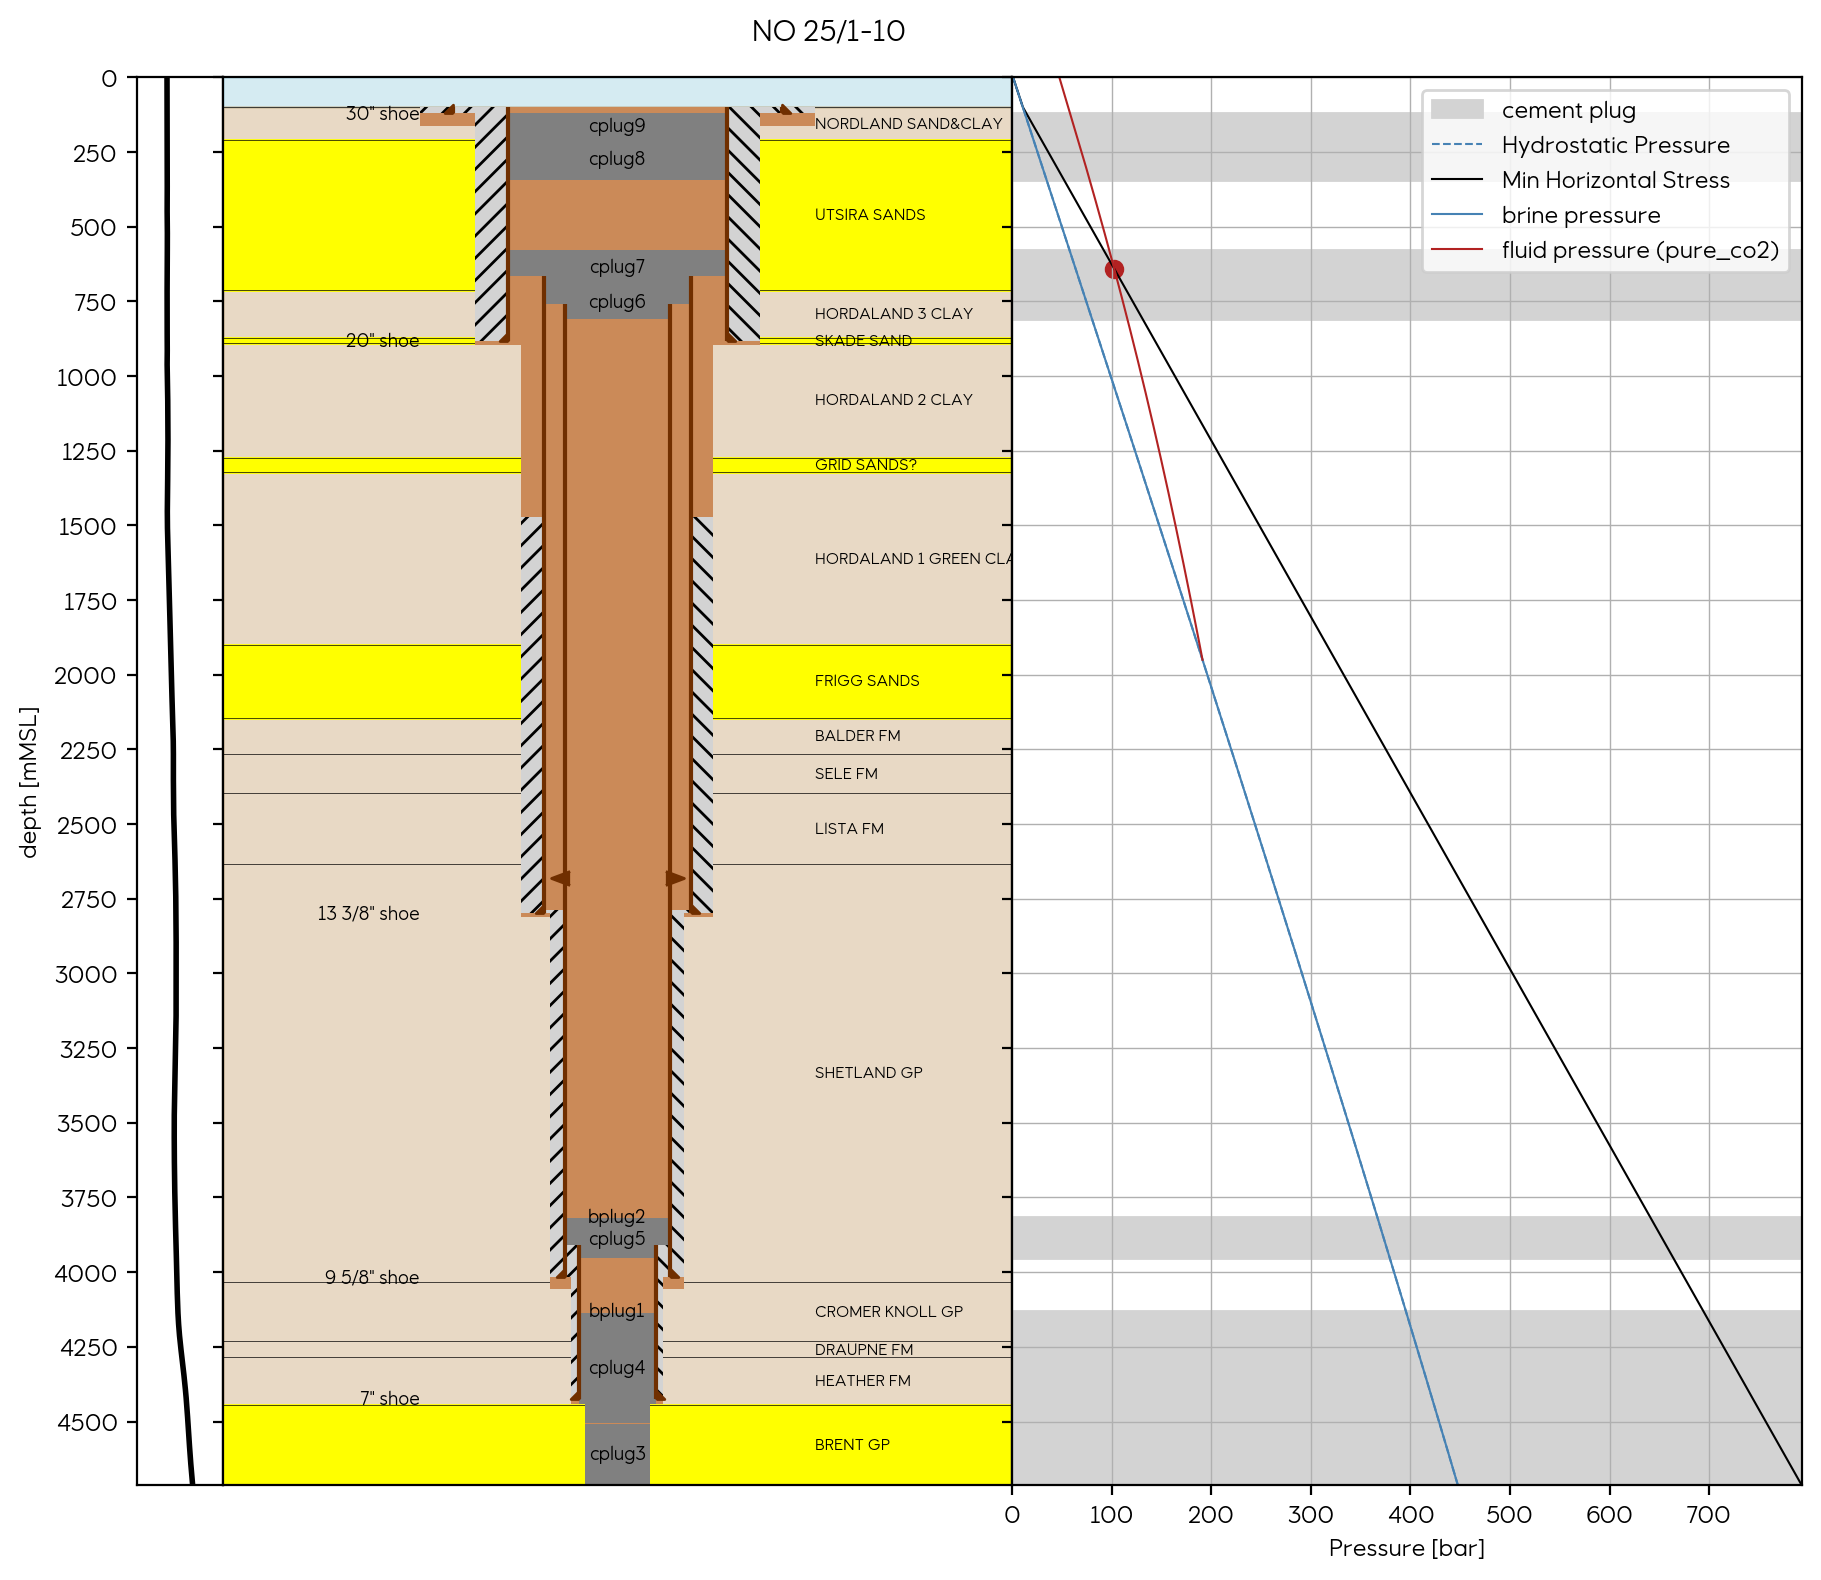

In [21]:
#Plot sketch, pressures
# fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
fig, (ax0, ax1, ax2) = plt.subplots(1,3, sharey=True, figsize=(10, 8))

ax0.plot(hoz_offset, welly_well.location.tvd, lw=2, label="welly", c='k')
# ax0.scatter([250,-250],[0,0])
ax0.set_aspect(1)
ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax0.set_xlim(hoz_offset.min()-100, hoz_offset.max()+100)

# plot well sketch
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
# Get y-axis label of ax1
y_label = ax1.get_ylabel()

# Hide y-axis label of ax1
ax1.set_ylabel('')

# Set y-axis label of ax0
ax0.set_ylabel(y_label)

# plot pressure
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
              plot_HSP=True, #plot brine hydrostatic gradient
              plot_MSAD= True, #plot minimum safety abandonment depth
              )

# plot perforations (not implemented in the class yet)
perf_size = 2
left_perf = [[perf_size/3, -perf_size/2], [-perf_size, 0], [perf_size/3, perf_size/2]]
right_perf = [[-perf_size/3, -perf_size/2], [perf_size, 0], [-perf_size/3, perf_size/2]]

casings_df  = pd.DataFrame(my_well.casings)

steelcolor = '#702F00'

step_z = 50
perf_top = welly_well.location.md2tvd(2705)-23.5
perf_bottom = welly_well.location.md2tvd(2705)-23.5
perf_z = np.arange(start = perf_top, stop = perf_bottom+step_z,step = step_z)
ax1.plot([((9+5/8)*0.0254)/2]*len(perf_z), perf_z, marker = right_perf, ms=10, c=steelcolor, zorder=100)
ax1.plot([-((9+5/8)*0.0254)/2]*len(perf_z), perf_z, marker = left_perf, ms=10, c=steelcolor, zorder=100)

# ax0.set_ylim(2250,0)
# ax2.set_xlim(0,350)

fig.suptitle(f'{my_well.header['well_name']}')
fig.tight_layout()
fig.subplots_adjust(wspace=0)

#routine to stretch ax1 and ax2 while keeping the first aspect ratio

pos_left = ax0.get_position()  # Get the original position
pos_right = ax1.get_position()
gap = pos_right.x0 - pos_left.x1     # Calculate the gap between the subplots

ax1.set_position([pos_right.x0 - gap, pos_right.y0, pos_right.width+gap/2, pos_right.height])

pos_left = ax1.get_position()  # Get the original position
pos_right = ax2.get_position()
gap = pos_right.x0 - pos_left.x1     # Calculate the gap between the subplots

ax2.set_position([pos_right.x0 - gap, pos_right.y0, pos_right.width+gap, pos_right.height])


